## 1. Aims, objectives and plan

### a) Aims and objectives (4 marks)
The main objectives for this project are creating two data models to analyse a freely chosen dataset, and 
writing a technical report about the analysis. The dataset of choice is the __CIFAR-10__ collection of images, and the two techniques are __SVM and Neural Network__. The primary motivation for this choice was to closely simulate modern real-world applications, demonstrating the differences between __kernel and non-kernel__ approaches of two widely recognised techniques.

The aim of this project is to compare the strengths and weaknesses of the two approaches on a fairly complex image classification task and provide a final best model with a satisfactory performance.

## 2. Understanding the case study

###  Case study analysis (8 marks)

1. The potential scope of techniques and optimisations on image data is nearly infinite. In this project, I will primarily focus on the differences between how kernel and non-kernel techniques make decisions, using the most standard architectures and hyperparameters where applicable.
2. The image data is very rich and complex, being larger, in colour, but also much more diverse within a class compared to for example the MNIST. Making accurate classifications will not be simple, and accuracies of 90%+ are likely unachievable within the scope of the project.
3. The data is evenly distributed and does not require a ton of pre-processing, allowing us to focus more on the workings of the models.
4. While model performance should cover appropriate accuracy metrics, the complexity of the data will make training times another important factor to consider, as training a model for days is not viable for this project.
5. Especially during cross-validation, it might not viable to run models on all data due to the training times. Taking subsets of the data, using only one colour channel, or perhaps even PCA are among the candidates to limit training times without giving up important validation techniques.

## 3. Dataset description (8 marks)

1. The dataset consists of 60,000 images (50,000 for training and 10,000 pre-made for testing, with 6,000 even distributions per class)
2. The images are 32x32 pixels, in colour (3 RGB channels)
3. While the images do not require a ton of pre-processing, they will still require flattening, scaling or normalisation which will be specific to the technique used.
4. There are 10 completely mutually exclusive classes - Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck
5. The dataset is available from https://www.cs.toronto.edu/~kriz/cifar.html or directly from Python ML libraries (this method will be used in this project to avoid manual downloading of data)
6. The data is already in a fairly easy-to-work with format, so we can visualize it as below:

(50000, 32, 32, 3)


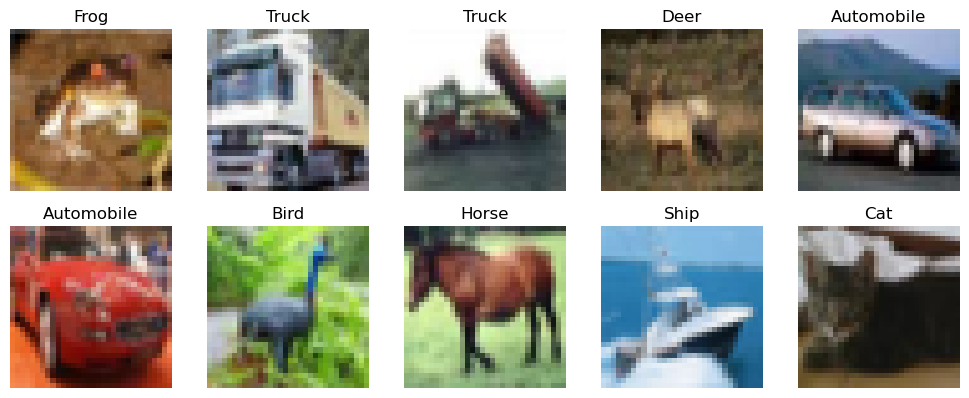

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

# Easy import via keras datasets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def plot_images(images, labels, class_names, num_images=10):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i][0]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

(print(x_train.shape))
plot_images(x_train, y_train, class_names)

There are indeed 50,000 32x32 training images in 3 colour channels. They have just enough detail for a human to be able to identify most of the objects. As already mentioned, the difference between images of the same category can be very big and false positives or negatives are going to be hard to avoid. Further pre-processing will be done individually for each technique. Lastly, we can show the image in terms of its colour values to understand better how it is constructed and appreciate the complexity of the data that the models will have to crunch through.

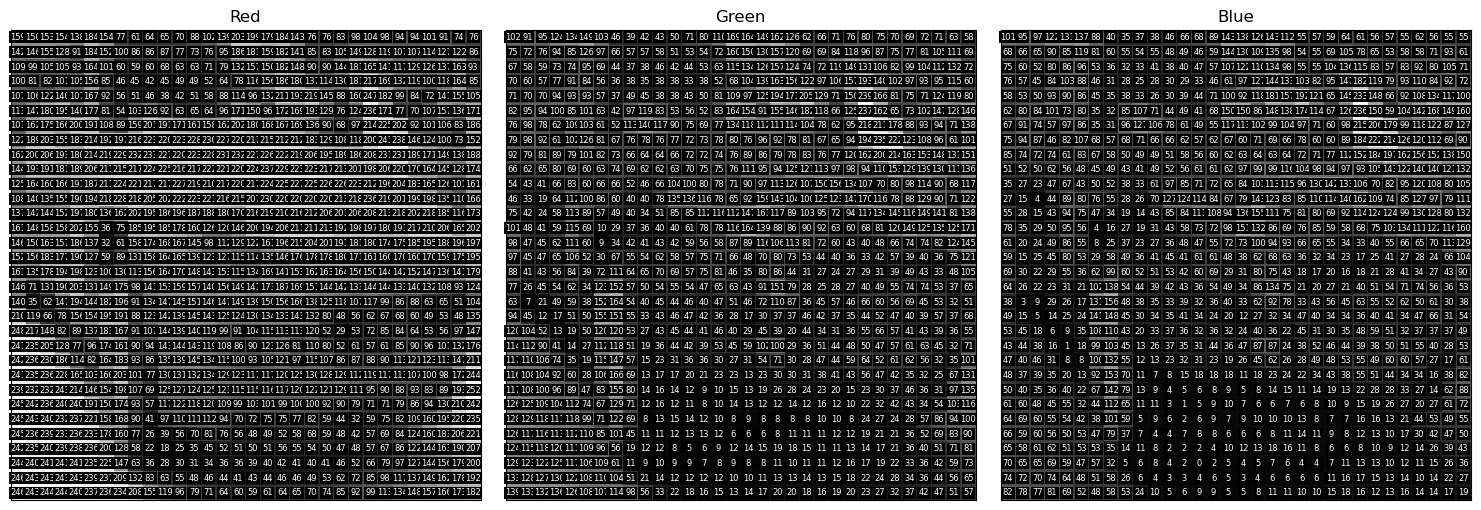

In [2]:
image = x_train[5] # Image of the car selected

# Split the image into its colour channels and plot values on grayscale (other colour scales made the car harder to recognise)
red_channel = image[:, :, 0]
green_channel = image[:, :, 1]
blue_channel = image[:, :, 2]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
channel_titles = ['Red', 'Green', 'Blue']
channels = [red_channel, green_channel, blue_channel]

for i, ax in enumerate(axs):
    ax.imshow(channels[i], cmap='gray')
    ax.set_title(channel_titles[i])
    height, width = channels[i].shape
    for row in range(height):
        for col in range(width):
            pixel_value = channels[i][row, col]
            ax.text(col, row, str(pixel_value), ha='center', va='center', fontsize=6, color='white', 
                    bbox=dict(facecolor='black', edgecolor='none', pad=1))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

## 4. Support Vector Machines

### a) Discuss your motivation for choosing the technique and provide a schematic figure of the process (8 marks)

SVM was chosen to demonstrate the mechanics of kernel methods on a widely used technique. SVM solves an optimisation problem that maximises the margins between classes and a hyperplane, using kernel functions which measure the distance between two points. To deal with non-linearity, input data can be mapped into higher-dimensional feature spaces, and through the kernel trick, we can only deal with the kernel function instead of the feature space directly. This enables SVM to make even complex image classification boundaries where linear regression would fall short due to requiring millions of polynomial coefficients, among other problems. SVMs also come with convergence guarantees unlike many other techniques.

Although powerful, SVMs are not tailored for such large, complex datasets. Firstly, more internal classifiers must be combined for multi-class problems. Secondly, a slack variable controlled by the regularisation hyperparameter C must be introduced to handle data that is not perfectly separable, adjusting the trade-off between the slack penalty and the margins. Lastly, their complexity scales with O(N^3) and so training times might be high. The idea of choosing SVM is to show how despite all this, the kernel mechanism can still offer decent results even on such complex data and can also provide an interpretable edge boundary for each class.

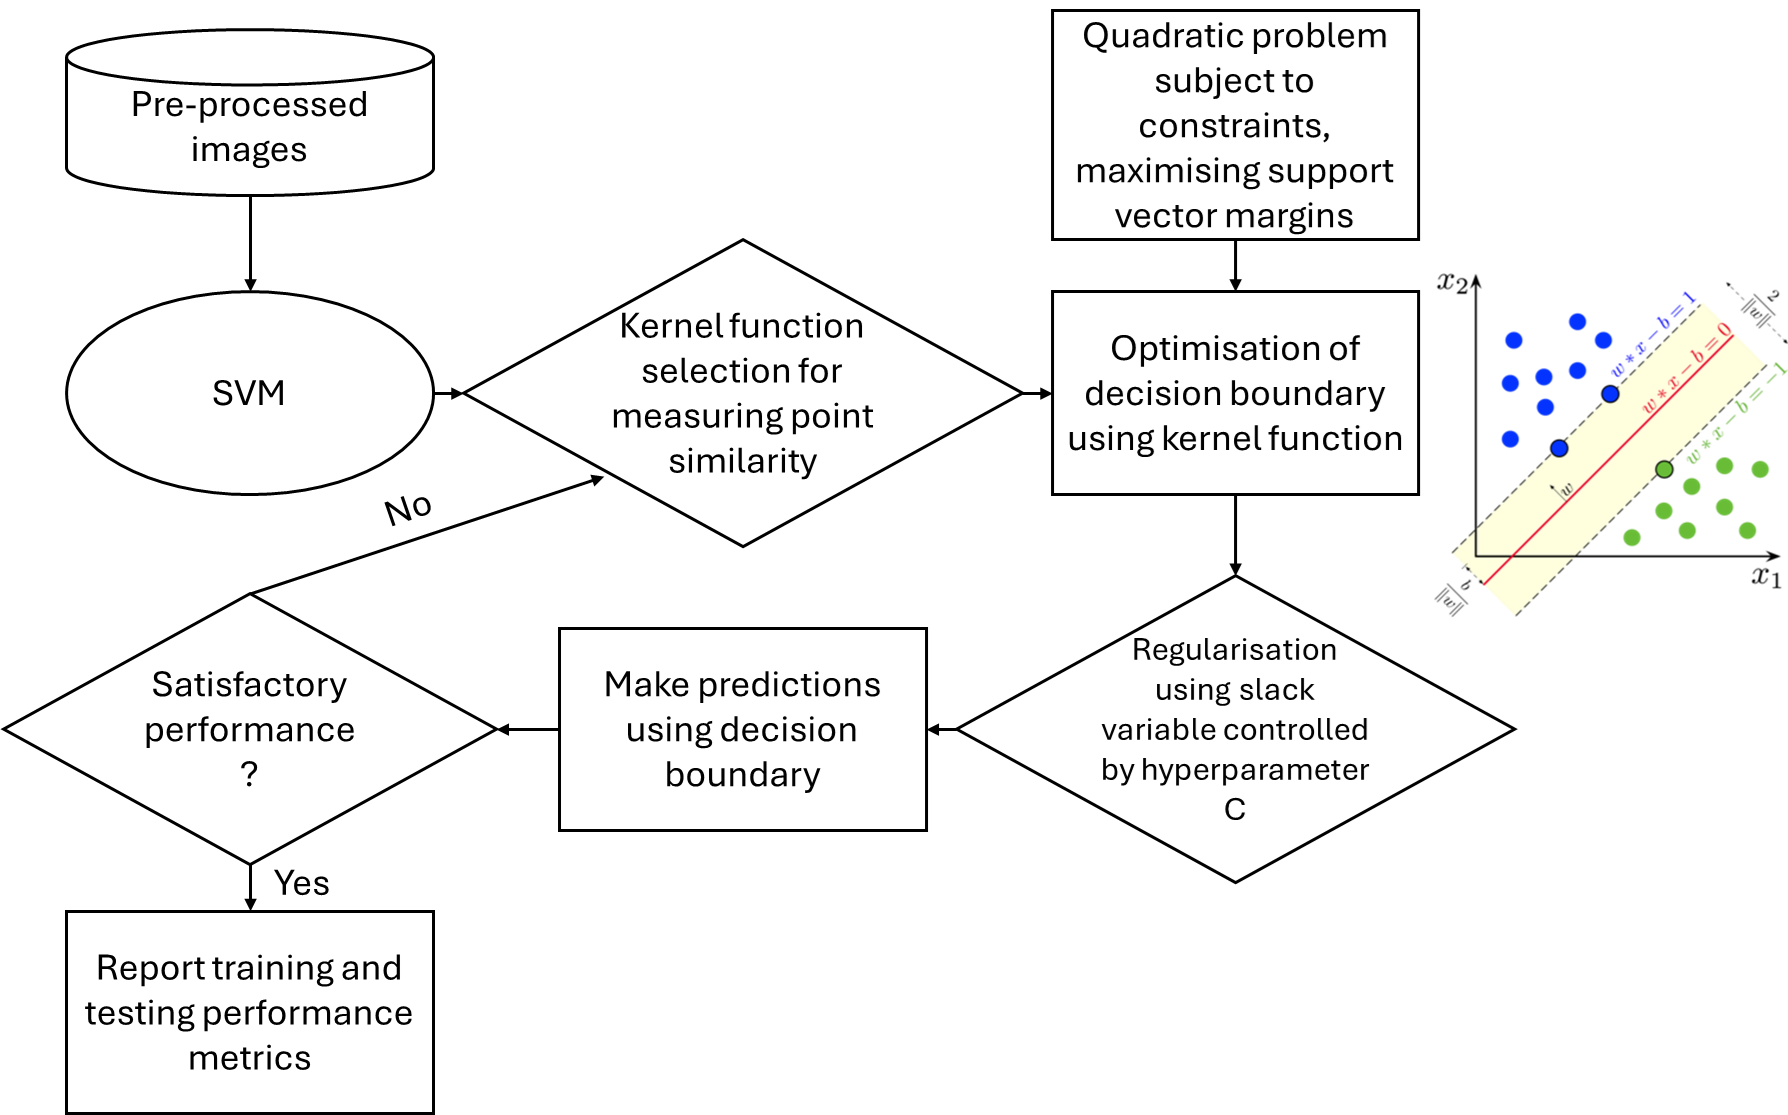

### b) Setting hyper parameters (rationale) (5 marks)

As discussed, the main hyperparameters for SVM are the kernel function and C. Three of the most standard kernel functions and a standard range from small to large C (0.1, 1 and 10) will be tested further. Other hyperparameters are kept default to avoid the exponential training time costs during grid-search CV and maximum iterations are adjusted to allow for convergence.

I chose to use a standard SVM from scikit-learn to be able to focus more on the hyperparameters than constructing the architecture manually and dealing with inefficient implementation. There we can also use Linear-SVC or SVC. Main differences are in loss functions and the use of one-vs-rest and one-vs-one methods for multi-class problems. This means creating a classifier for each class against all other classes, or one for each pair of classes. Linear-SVC also allows us to directly use a primal (63) instead of dual representation (60) of the optimisation problem.

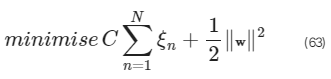
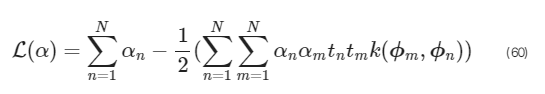

Chapter 7 from Bishop (2006) predicts better efficiency for primal representation in image classification where number of features is much higher than number of samples. We can test the linear implementations as below. Given the amount of testing to be done and SVM's O(N^3) complexity, we need to reduce the sample size to a more manageable number. We also need to flatten and normalise all inputs to the model.

In [3]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
import time

In [4]:
# Normalise the image data between 0-1 and flatten
x_train_svm = x_train.reshape(x_train.shape[0], -1).astype('float32') / 255.0
x_test_svm = x_test.reshape(x_test.shape[0], -1).astype('float32') / 255.0

# Choose a random subset of the data to reduce training times
np.random.seed(1) # For replicability
n_samples = 1000
indices = np.random.choice(x_train_svm.shape[0], n_samples, replace=False)
x_train_svm = x_train_svm[indices]
y_train_svm = y_train[indices].flatten()

In [5]:
def svm_test(model, dual=False):
    if model=='lin':
        svm_model = LinearSVC(C=1.0, dual=dual, max_iter=100000, verbose=0) # High max iterations to train until the end
    else:
        svm_model = SVC(kernel='linear', C=1.0, max_iter=100000, verbose=0)
    start_time = time.time()
    svm_model.fit(x_train_svm, y_train_svm)
    training_time = time.time() - start_time
    y_pred = svm_model.predict(x_test_svm)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, training_time

accuracy, training_time = svm_test(model='lin', dual=False)
print("Primal LinearSVC - Accuracy:", round(accuracy, 2), "Training Time:", round(training_time, 2), "seconds.")
accuracy, training_time = svm_test(model='lin', dual=True)
print("Dual LinearSVC - Accuracy:", round(accuracy, 2), "Training Time:", round(training_time, 2), "seconds.")
accuracy, training_time = svm_test(model='svc')
print("SVC with linear Kernel - Accuracy:", round(accuracy, 2), "Training Time:", round(training_time, 2), "seconds.")

Primal LinearSVC - Accuracy: 0.24 Training Time: 13.25 seconds.
Dual LinearSVC - Accuracy: 0.24 Training Time: 108.6 seconds.
SVC with linear Kernel - Accuracy: 0.3 Training Time: 0.79 seconds.


This confirms the efficiency of primal representation, achieving the same accuracy as dual representation (as it should in theory) but much faster. However, we also surprisingly get way better performance (particularly in training times) with normal SVC with a linear kernel. This could be due to a smaller sample size and the mentioned differences, or just the SVC library being better with non-linear data. Nonetheless, given that training time is a significant bottleneck, I will prefer to use it and thus we can set the parameter grid as below:

In [6]:
param_grid_svm = [{'classifier': [SVC()],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['poly', 'rbf', 'sigmoid']}]

### c) Optimising hyper parameters (5 marks) 


A grid-search CV will be performed to get best model hyperparameters. Although computationally expensive, this is needed to have confidence in especially the setting of parameter C, which could otherwise be easily overfitted and requires data to be held out. To compensate, we are using a sample of the data and low numbers of folds, which would ideally be larger with more powerful hardware.

Due to this, the reported accuracies from this search are important in relation to each other, rather than being representative of final model performance. However, the hyperparameters should be validated against each other and the best combination can be used to train a final, more full model.

In [7]:
# Prepare pipeline with scaling, which is recommended even after normalisation given SVM sensitivity to scale
pipe_svm = Pipeline([
    ('prep', StandardScaler()),
    ('classifier', SVC(max_iter=5000))])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1) # Stratified just in case of poor split of balanced categories

search_svm = GridSearchCV(pipe_svm, param_grid=param_grid_svm, cv=cv, scoring="accuracy", verbose=3) # Simple accuracy due to class balance
search_svm.fit(x_train_svm, y_train_svm)
scores = search_svm.best_score_
best = search_svm.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END classifier=SVC(), classifier__C=0.1, classifier__kernel=poly;, score=0.147 total time=   0.4s
[CV 2/3] END classifier=SVC(), classifier__C=0.1, classifier__kernel=poly;, score=0.132 total time=   0.4s
[CV 3/3] END classifier=SVC(), classifier__C=0.1, classifier__kernel=poly;, score=0.147 total time=   0.4s
[CV 1/3] END classifier=SVC(), classifier__C=0.1, classifier__kernel=rbf;, score=0.177 total time=   0.6s
[CV 2/3] END classifier=SVC(), classifier__C=0.1, classifier__kernel=rbf;, score=0.180 total time=   0.6s
[CV 3/3] END classifier=SVC(), classifier__C=0.1, classifier__kernel=rbf;, score=0.177 total time=   0.6s
[CV 1/3] END classifier=SVC(), classifier__C=0.1, classifier__kernel=sigmoid;, score=0.219 total time=   0.4s
[CV 2/3] END classifier=SVC(), classifier__C=0.1, classifier__kernel=sigmoid;, score=0.243 total time=   0.4s
[CV 3/3] END classifier=SVC(), classifier__C=0.1, classifier__kernel=sigmoid;, sc

In [8]:
print(best)
print(scores)

{'classifier': SVC(), 'classifier__C': 10, 'classifier__kernel': 'rbf'}
0.34500668333003665


In [9]:
from sklearn.model_selection import cross_val_predict

# Choose a new, larger subset
x_train_svm = x_train.reshape(x_train.shape[0], -1).astype('float32') / 255.0
x_test_svm = x_test.reshape(x_test.shape[0], -1).astype('float32') / 255.0

np.random.seed(2)
n_samples = 20000
indices = np.random.choice(x_train_svm.shape[0], n_samples, replace=False)
x_train_svm2 = x_train_svm[indices]
y_train_svm2 = y_train[indices].flatten()

# Use best parameters to fit pipeline 
pipe_svm.set_params(**best)
start = time.time()
pipe_svm.fit(x_train_svm2, y_train_svm2)
end = time.time()
traintime_svm = round(end-start,1)
print("Finished fitting SVM pipeline. Duration:", traintime_svm, "seconds.")

# Do a cross-validated prediction to get a sense of final testing performance
start = time.time()
y_pred_svm = cross_val_predict(pipe_svm, x_train_svm2, y_train_svm2.flatten(), cv=3)
end = time.time()
print("Finished predictions. Duration:", round(end-start,1), "seconds.")

Finished fitting SVM pipeline. Duration: 519.3 seconds.
Finished predictions. Duration: 1126.1 seconds.


### d) Performance metrics for training (5 marks)

In [10]:
print("Training accuracy:")
print(accuracy_score(y_train_svm2, y_pred_svm))

print("\nF1 Score:")
print(f1_score(y_train_svm2, y_pred_svm, average="weighted"))

print("\nConfusion Matrix:")
print(confusion_matrix(y_train_svm2, y_pred_svm))

Training accuracy:
0.4955

F1 Score:
0.4958335570718862

Confusion Matrix:
[[1113   95  120   67   64   49   37   72  260  123]
 [  88 1222   34   64   22   39   37   43  116  310]
 [ 180   30  799  170  287  154  179  109   50   52]
 [  67   77  200  709  131  395  177  106   48  101]
 [ 112   39  312  131  855  107  170  167   47   45]
 [  49   55  192  467  122  754  144  127   39   52]
 [  29   43  210  235  212  123 1040   48   26   50]
 [  86   67  133  149  178  135   61 1067   34  108]
 [ 242  122   49   68   43   57   27   21 1249  101]
 [ 110  339   51   82   42   67   38   80   94 1102]]


The final training accuracy of 50% is not ideal, but not terrible (compared to 10% of random guessing). Keep in mind that we still only use a subset of data for training, so the results would likely be even better with several hours of training. On the other hand, this should further work against overfitting, so the testing performance should not be vastly different from this. The fitting with this subset takes around 9 minutes, but making the cross-validated predictions which requires the fitting and predictions on 3 folds takes almost 19 minutes. The predictions with SVM take a significant amount of time due to the kernel transformations and having many support vectors on such complex data, as described by the prediction equation:

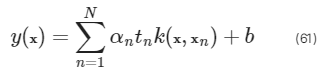

The SVM kernel engine of similarity between classes can give us a glimpse into the features that it considers important when deciding between classes for a particular image. We can visualise the support vectors as below:

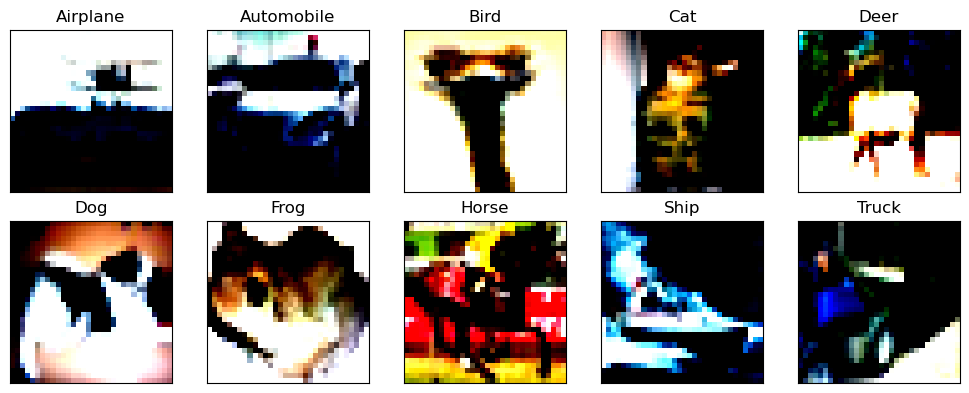

In [11]:
# Get the support vectors
support_vector_indices = pipe_svm.named_steps['classifier'].support_
support_vectors = pipe_svm.named_steps['classifier'].support_vectors_
y_support_vectors = y_train_svm2[support_vector_indices]

# Plot the support vectors for the first instance of each class
plt.figure(figsize=(10, 4))
n_classes = np.unique(y_support_vectors).shape[0]

for i in range(n_classes):
    ax = plt.subplot(2, 5, i + 1)
    indices = np.where(y_support_vectors == i)[0]
    sv_image = support_vectors[indices[0]].reshape(32, 32, 3)
    sv_image = np.clip(sv_image, 0, 1)
    ax.imshow(sv_image)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(class_names[i])
plt.tight_layout()
plt.show()

## 5. Neural Networks

### a) Discuss your motivation for choosing the technique and  provide a schematic figure of the process (8 marks)

Neural networks are selected as a non-kernel method in contrast to SVMs. Rather than measuring point similarities using a fixed kernel transformation to determine a boundary, NNs are able to capture and learn extremely complex patterns from the data itself through a vast network of layers and nodes, which run the weights for each pixel to make decisions and minimise classification error using backpropagation. Bishop (2006) considers NNs "regressors that are able to learn their own basis functions". Their large, but not astronomical amounts of learnable parameters make them the preferred method for complex data such as images. Not having O(N^3) complexity and being able to utilise GPUs is another imporant factor for why NNs are generally used in such tasks.

Some downsides of NNs lie in their more complex inner workings, making them harder to fine-tune, or explain how exactly they reach conclusions. Furthermore, unlike SVMs they also have no convergence guarantees. This section will look at two NN architectures to demonstrate the capabilities of adding more and more complex layers.

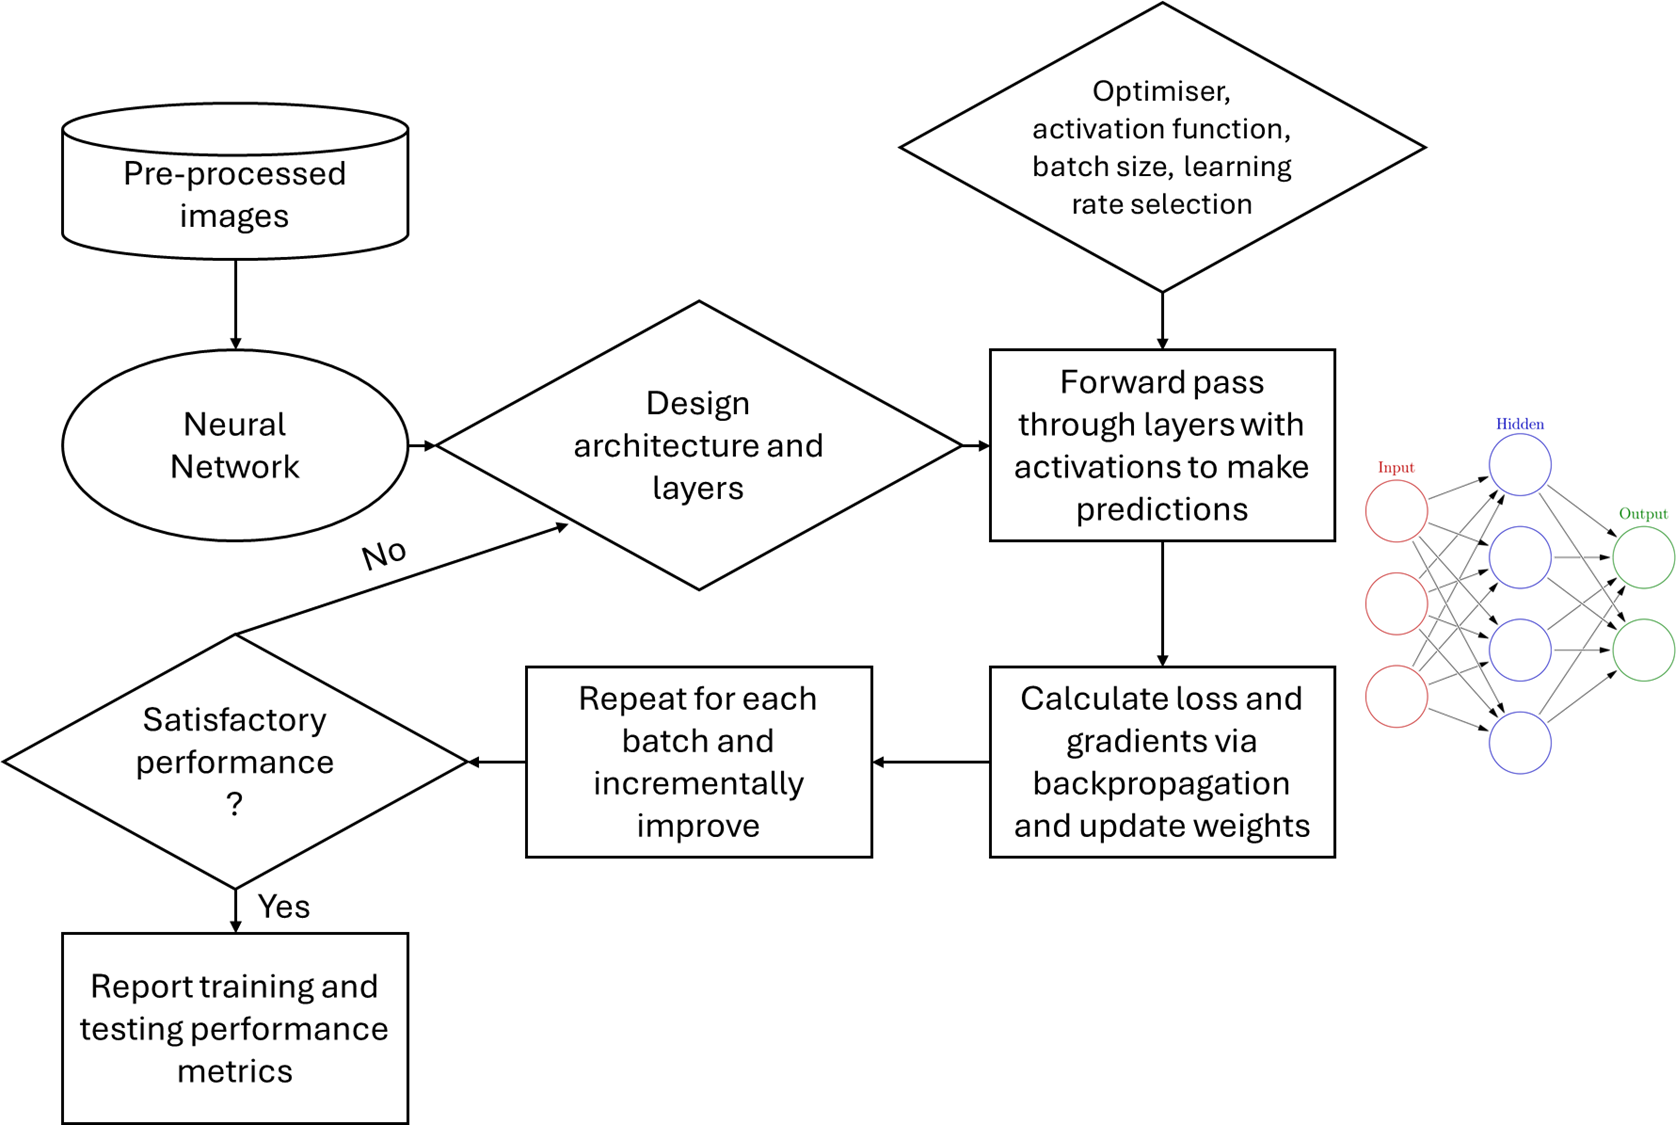

### b) Setting hyper parameters (rationale) (5 marks)

The architecture of the neural network is itself probably the most important decision. I will first use a Multilayer Perceptron as the simplest NN to showcase the learning mechanics compared to SVM. I will then create a much more powerful, image-native NN to generate a final model.

There are a lot of hyperparameters that can be adjusted for neural networks. As previously discussed, the aim is not to get the most optimal classifier for this task, but to showcase the differences in decision making, which is why only the ones which affect this will be considered, as per the weight update equation below:

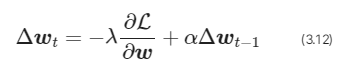 (L2 regularisation penalty would be added to the loss)

I will test the standard activations, which adjust how data is propagated and squashed. Standard gradient descent will be used, as more advanced techniques like Adam are out of scope for this project. The learning rate, adjusting the step size towards the gradient when updating weights, will be tested, as well as momentum which helps accelerate and smooth out updates by using fraction of previous weight gradients, and regularisation, which is added to loss to prevent overly large weights and overfitting. The values for them are chosen to showcase a conservative to high effect of each of the choices.

Due to the amount of hyperparameters and testing, I will showcase their effects one by one, instead of a thorough grid search selecting the optimal combination.

In [12]:
activations_mlp = [{'classifier__activation': ['identity', 'logistic', 'tanh', 'relu']}]
lr_mlp = [{'classifier__learning_rate_init': [0.001, 0.01, 0.05]}]
alpha_mlp = [{'classifier__alpha': [0.0001, 0.1, 1]}]
momentum_mlp = [{'classifier__momentum': [0.6, 0.9, 0.99]}]

### c) Optimising hyper parameters (5 marks)


While neural networks do not depend on O(N^3) and we can use the full sample for training, they do depend on the complexity of the network itself and the depth of training. To showcase differences between the hyperparameters, I will use a non-nested CV (to prevent overfitting at least to some degree) with short iterations, which as for SVM will not provide a full picture of the final performance of the network, rather help us to select a final version to train further. I use the standard MLPClassifier from scikit-learn again.

In [13]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings("ignore", category=ConvergenceWarning) # Not all runs will converge in this shallow testing

# Normalise and flatten the image data
x_train_mlp = x_train.reshape(x_train.shape[0], -1).astype('float32') / 255.0
x_test_mlp = x_test.reshape(x_test.shape[0], -1).astype('float32') / 255.0

# Prepare pipeline with scaling, kept identical to SVM to minimise differences
pipe_mlp = Pipeline([
    ('prep', StandardScaler()),
    ('classifier', MLPClassifier(solver='sgd', max_iter=30))])
test_scores = []

# Non-nested CV for each hyperparameter grid
for x in [activations_mlp, lr_mlp, alpha_mlp, momentum_mlp]:
    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=1) 
    search_mlp = GridSearchCV(pipe_mlp, param_grid=x, cv=cv, scoring="accuracy", verbose=3)
    search_mlp.fit(x_train_mlp, y_train.flatten())
    results = search_mlp.cv_results_
    test_scores.append(results['mean_test_score'])

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END ...classifier__activation=identity;, score=0.392 total time=  17.0s
[CV 2/2] END ...classifier__activation=identity;, score=0.387 total time=  16.9s
[CV 1/2] END ...classifier__activation=logistic;, score=0.404 total time=  17.3s
[CV 2/2] END ...classifier__activation=logistic;, score=0.407 total time=  17.2s
[CV 1/2] END .......classifier__activation=tanh;, score=0.431 total time=  17.1s
[CV 2/2] END .......classifier__activation=tanh;, score=0.429 total time=  17.1s
[CV 1/2] END .......classifier__activation=relu;, score=0.476 total time=  17.3s
[CV 2/2] END .......classifier__activation=relu;, score=0.482 total time=  17.1s
Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV 1/2] END classifier__learning_rate_init=0.001;, score=0.480 total time=  17.2s
[CV 2/2] END classifier__learning_rate_init=0.001;, score=0.481 total time=  17.2s
[CV 1/2] END classifier__learning_rate_init=0.01;, score=0.463 total

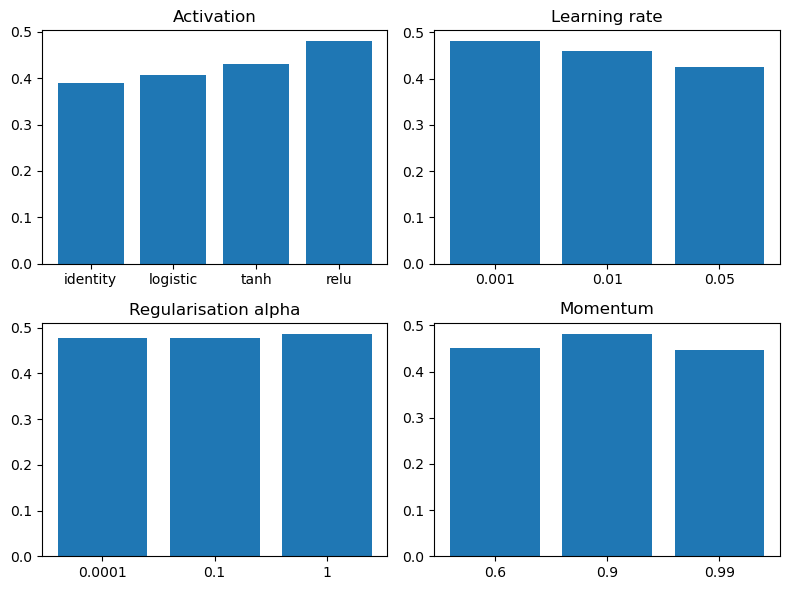

In [14]:
# Plot the mean results
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
t = 0
cats = [activations_mlp[0]['classifier__activation'], list(map(str, lr_mlp[0]['classifier__learning_rate_init'])),
        list(map(str, alpha_mlp[0]['classifier__alpha'])), list(map(str, momentum_mlp[0]['classifier__momentum']))]
names = ["Activation", "Learning rate", "Regularisation alpha", "Momentum"]

for i in range(2):
    for j in range(2):
        axs[i][j].bar(cats[t], test_scores[t])
        axs[i][j].set_title(names[t])
        t+=1
plt.tight_layout()
plt.show()

The MLP for this task prefers the most used relu activation (f(x)=max(0,x)), a low learning rate, medium momentum, and higher values of regularisation. Although this is far from a proper validated search which would take ages, we can reasonably use these estimates to train a slightly larger version of the network, with cross-validated predictions.

In [15]:
# Use found parameters and larger layer size
pipe_mlp = Pipeline([
    ('prep', StandardScaler()),
    ('classifier', MLPClassifier(solver='sgd', learning_rate_init=0.001, momentum=0.9, max_iter=100, hidden_layer_sizes=(1024), alpha=1))])

# Fit and use CV predictions for better estimate of final performance
start = time.time()
pipe_mlp.fit(x_train_mlp, y_train.flatten())
end = time.time()
traintime_mlp = round(end-start,1)
print("Finished fitting MLP pipeline. Duration:", traintime_mlp, "seconds.")

start = time.time()
y_pred_mlp = cross_val_predict(pipe_mlp, x_train_mlp, y_train.flatten(), cv=3)
end = time.time()
print("Finished predictions. Duration:", round(end-start,1), "seconds.")

Finished fitting MLP pipeline. Duration: 721.6 seconds.
Finished predictions. Duration: 1471.4 seconds.


In [16]:
print("Training accuracy:")
print(accuracy_score(y_train.flatten(), y_pred_mlp))

print("\nF1 Score:")
print(f1_score(y_train.flatten(), y_pred_mlp, average="weighted"))

print("\nConfusion Matrix:")
print(confusion_matrix(y_train.flatten(), y_pred_mlp))

Training accuracy:
0.54038

F1 Score:
0.5402334173807921

Confusion Matrix:
[[2959  188  292  135  182   99  112  139  599  295]
 [ 197 3123   96  117   86   49  135   96  335  766]
 [ 343   86 2056  448  771  371  439  253  107  126]
 [ 121   84  457 1910  331  987  512  236  139  223]
 [ 230   72  637  335 2416  292  390  395  132  101]
 [  92   62  409 1109  326 2149  292  345   86  130]
 [  59   96  369  486  488  309 2883  128   73  109]
 [ 138   73  252  296  437  366  114 3040   80  204]
 [ 425  280  107  136  109   86   69   44 3465  279]
 [ 199  706   93  164   75  130  124  196  295 3018]]


The final training accuracy of 54% is slightly higher than for SVMs. While the MLP can learn on the full dataset without much problems, it struggles with adding complexity to its architecture and thus training times can actually be higher for the MLP than for SVM, especially during the fold training and predicting within the cross validation procedure. The 12 minutes of fitting and another 25 for CV predictions is slightly more than what SVM had, but it only trained on 2/5 of the available data, because adding further points scaled cubically, which makes this MLP architecture much more scalable.

To get a well-performing neural network on such data, adding more and bigger MLP layers would however not be efficient, and we must look to much more advanced techniques. One such technique are convolutional neural networks, which utilise convolutional layers that can work with non-flattened image data to extract features, share weights and other tricks that make it much faster and accurate on complex image data. The exact architecture is enough for another project, but a simple diagram is shown below.

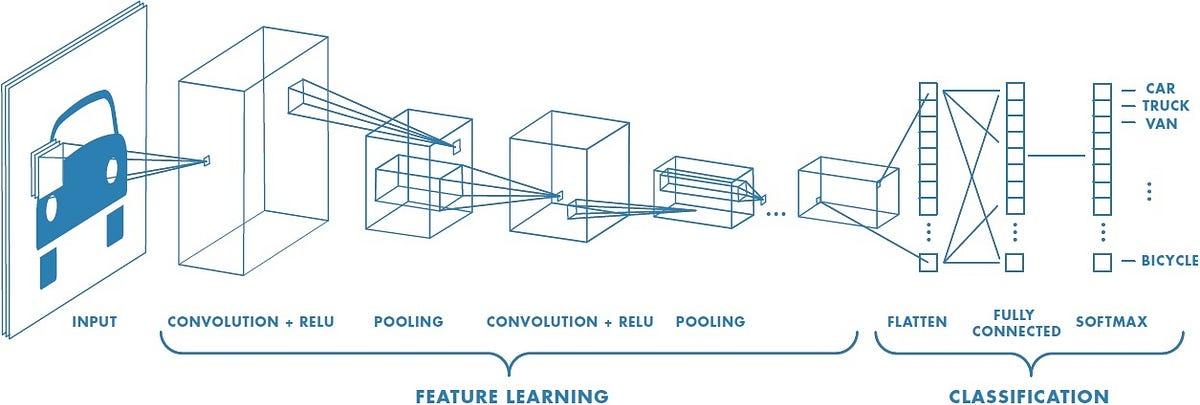
(Source: https://medium.com/@RaghavPrabhu/understanding-of-convolutional-neural-network-cnn-deep-learning-99760835f148)

An architecture that worked well in my testing is shown here as more of an example of the power of the underlying neural network setup when optimised and expanded beyond MLP. Having multiple layers allows for the capture of even rich image data features, compared to kernel methods such as SVM, which are subject to fixed kernel methods and cannot replicate such capabilities simply by differences between points. I use tensorflow keras for the CNN, which provided all the necessary parameters.

In [17]:
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD

# Conv layers can work with non-flattened image data
x_train_nn = x_train.astype('float32') / 255.0
x_test_nn = x_test.astype('float32') / 255.0

nn = keras.Sequential([
    layers.Input(shape=(32, 32, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),  
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# Use previously found hyperparameters to compare performance
custom_sgd = SGD(learning_rate=0.01, momentum=0.9)
nn.compile(optimizer=custom_sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Scaling for CNNs is usually not beneficial, as they can capture image structure
# Validation split is used to evaluate the model's overfitting during training, without a separate test set or CV
start = time.time()
train_nn = nn.fit(x_train_nn, y_train.flatten(), epochs=50, batch_size=128, validation_split=0.2)
end = time.time()
traintime_cnn = round(end-start, 1)
print("Finished fitting NN. Duration:", traintime_cnn, "seconds.")

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.1725 - loss: 2.2005 - val_accuracy: 0.3368 - val_loss: 1.8045
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.3494 - loss: 1.7731 - val_accuracy: 0.4339 - val_loss: 1.5626
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.4260 - loss: 1.5796 - val_accuracy: 0.5039 - val_loss: 1.3875
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.4738 - loss: 1.4437 - val_accuracy: 0.5345 - val_loss: 1.2965
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5069 - loss: 1.3630 - val_accuracy: 0.5571 - val_loss: 1.2391
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5284 - loss: 1.3079 - val_accuracy: 0.5706 - val_loss: 1.1910
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5669 - loss: 1.2159 - val_accuracy: 0.6147 - val_loss: 1.0863
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5836 - loss: 1.1608 - val_accu

### d) Performance metrics for training (5 marks)

The fitting of the neural network was done with a small validation set to prevent overfitting. The accuracy evolution with each epoch is shown below.

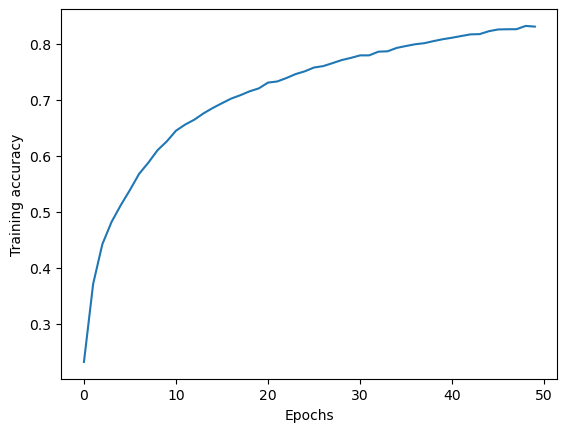

In [18]:
plt.plot(train_nn.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Training accuracy')
plt.show()

In [19]:
train_nn.history['val_accuracy'][-1]

0.7958999872207642

The final validation accuracy, which should give the best indication of final testing performance is 80%, which is much higher than for both SVM and the MLP.

## 6. Comparison of metrics performance for testing 

### a) Examining over-fitting (4 marks)

Grid search CV was used for hyperparameter selection and measure of accuracy for SVM. Due to the training times, only a subset of data was used for the final best model training, making the training predictions "blind" and likely not subject to much overfitting, on top of the cross validation of predictions. The regularisation parameter C also plays a role in reducing overfitting.

The neural networks use variable alpha that prevents weights growing too large and thus combatting overfitting. To save on training times, a full grid search is not conducted for hyperparameter tuning, but the MLP uses cross-validated predictions and the final best neural network also uses its own validation split and reports validation accuracies during training. These were not vastly different to the standard accuracies, suggesting that no major overfitting occured, primarily due to the presence of several dropout layers, which prevent this by randomly switching off neurons to avoid over-dependencies on particular nodes.

Overfitting could still occur primarily due to smaller than ideal cross-validation folds due to training times and this will be discussed after examining the final test results.

### b) Comparison with appropriate metrics for testing (4 marks)

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score

def Metrics(technique, xtest):
    start = time.time()
    y_pred = technique.predict(xtest)
    if technique == nn:
        y_pred = y_pred.argmax(axis=1) # Keras NN returns full continous probabilities for all classes
    end = time.time()
    predtime = round(end-start, 1)
    print("Prediction time:", predtime, "seconds.")
    print("Accuracy:", round(accuracy_score(y_test.flatten(), y_pred)*100, 2))
    f1 = round(f1_score(y_test, y_pred, average='weighted')*100, 2)
    print("F1 score:", f1)
    print("Precision:", round(precision_score(y_test, y_pred, average='weighted')*100, 2))
    print("Recall:", round(recall_score(y_test, y_pred, average='weighted')*100, 2))
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_pred)) # No standardisation needed due to class balance
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot()
    plt.show()
    return predtime, f1, y_pred

Prediction time: 285.9 seconds.
Accuracy: 51.71
F1 score: 51.81
Precision: 51.98
Recall: 51.71


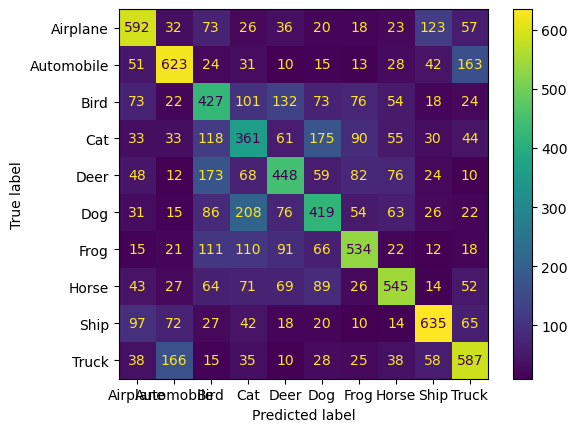

In [21]:
metrics_svm = Metrics(pipe_svm, x_test_svm)

Prediction time: 0.3 seconds.
Accuracy: 56.34
F1 score: 56.21
Precision: 56.21
Recall: 56.34


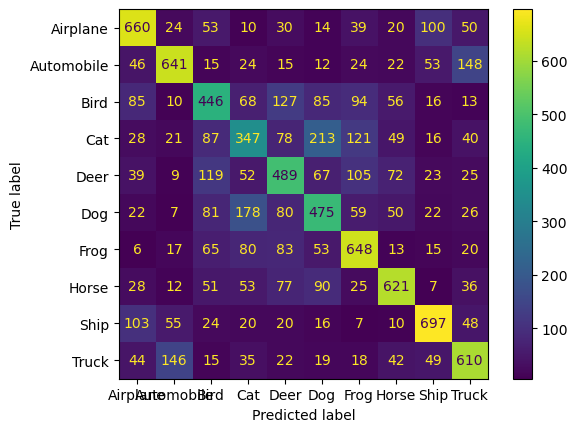

In [22]:
metrics_mlp = Metrics(pipe_mlp, x_test_mlp)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Prediction time: 0.9 seconds.
Accuracy: 79.02
F1 score: 78.85
Precision: 79.02
Recall: 79.02


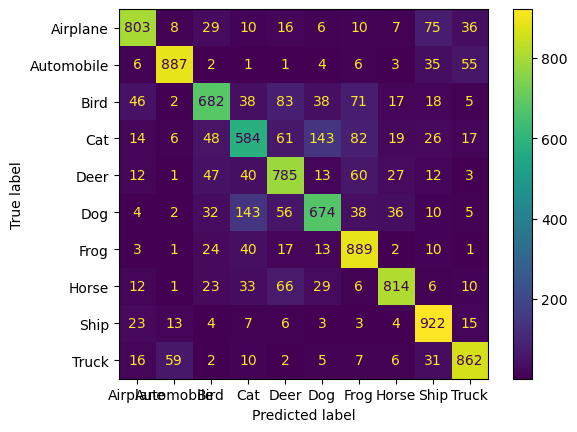

In [23]:
metrics_cnn = Metrics(nn, x_test_nn) # Predictions done in batches (default is 32)

The training accuracies of 50%, 54% and 80% for the 3 models respectively are very close to the final testing accuracies, supporting the previous argument that no overfitting should occur. Due to the balance of data, all the accuracy measures are roughly the same. From the classification matrix, we can also see that despite very different architectures, all models struggled with nearly the same categories, primarily with "Cat", often confusing it with "Dog". Other common misclassifications show on the "Airplane" vs. "Ship" and "Automobile" vs. "Truck" predictions. These are all logical due to the similarities between the objects and thus the features that the model use to differentiate between them.

Below I plot the first 10 images that all models got wrong.

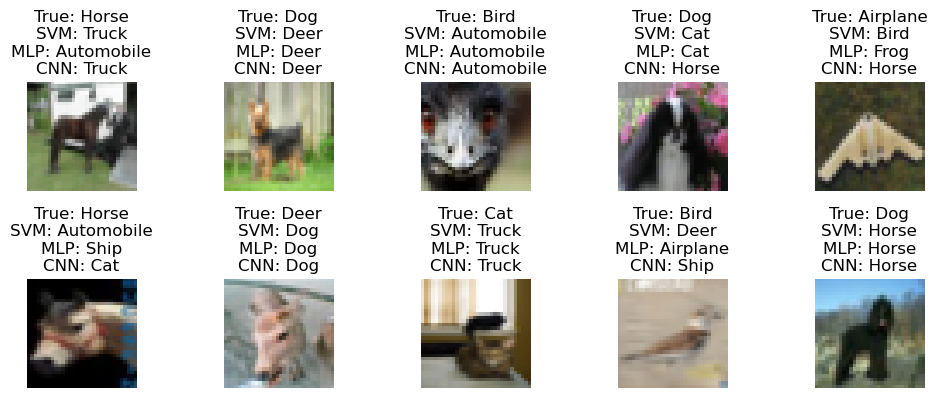

In [24]:
incorrect = np.where((metrics_svm[2] != y_test.flatten()) & (metrics_mlp[2] != y_test.flatten()) & (metrics_cnn[2] != y_test.flatten()))[0]
first_10 = incorrect[:10]

plt.figure(figsize=(10, 10))

for i, idx in enumerate(first_10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_test[idx])
    plt.title(f"True: {class_names[y_test.flatten()[idx]]}\n"
              f"SVM: {class_names[metrics_svm[2][idx]]}\n"
              f"MLP: {class_names[metrics_mlp[2][idx]]}\n"
              f"CNN: {class_names[metrics_cnn[2][idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Most of these images might be confusing to humans as well and often the models predict the same category, since the image looks more similar to another class' features. This is a good sign for the final model usability.

### c) Model selection (4 marks)

The final model selection will look at the two main objectives outlined earlier - accuracy, and training times. The measure of accuracy will use the f1 score, presenting a unified view of precision and recall (although these are fairly balanced due to the nature of the dataset). The training times will combine the original fit of the model/pipeline, as well as the testing predictions, which are significant for kernel methods which have to calculate the kernel function for each new sample against all support vectors, but nearly instant for NNs which simply multiply the weights with inputs as needed.

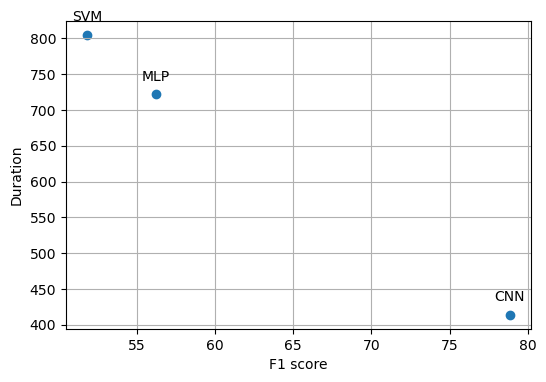

In [25]:
models = ['SVM', 'MLP', 'CNN']
durations = [metrics_svm[0] + traintime_svm, metrics_mlp[0] + traintime_mlp, metrics_cnn[0] + traintime_cnn]
metrics = [metrics_svm[1], metrics_mlp[1], metrics_cnn[1]]

plt.figure(figsize=(6, 4))
plt.scatter(metrics, durations)

for i, model in enumerate(models):
    plt.annotate(model, (metrics[i], durations[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.xlabel('F1 score')
plt.ylabel('Duration')
plt.grid(True)
plt.show()

## 7. Final recommendation of best model

### a) Discuss the results from a technical perspective, for example, overfitting discussion, complexity and efficiency (4 marks)

The usage of kernel methods such as SVM is very effective on smaller and less complex data, providing convergence guarantees and proper explainability of results using the boundaries produced by support vectors. However, it struggles with prediction times, and scalability due to its O(N^3) complexity, and the rich and vast image dataset presented in this project was more suitable for the non-kernel neural networks. These can utilise layers that can learn extremely high amounts of parameters necessary for such data, and the specialised convolutional layers push this even further, preserving and capturing the underlying patterns of images.

The final best model in this exercise is thus undoubtedly the CNN, providing the highest accuracies at the lowest training times. It does not overfit during training thanks to validation sets and reaches a testing accuracy of 79% in just around 7 minutes of training and predictions. It is however the hardest to fine-tune and properly understand.

### b) Discuss the results from a business perspective, for example, results interpretation, relevance and balance with technical perspective (4 marks)

Despite these results, we cannot conclude that kernel methods are inferior to non-kernel methods, or that SVM is inferior to MLP in general. Recognising synthetic datasets of images is not really a business use-case on its own and different applications might benefit from different aspects of a model.

The nature and amount of data will play a huge role in what technique should be selected. The costs of training an inefficient model for a certain task might be very high in real world applications. Furthermore, while a 79% accuracy seems good enough for this exercise, the use of image classification models in automotive or medical sectors might be subject to way higher standards, especially when it comes to precision. On the other hand, some other uses might be happy with accuracies above random guess and prefer the benefits of other techniques. For example, explainability might be key in certain applications, such as provision of loans or other law-regulated areas, where the easier to understand and visualise, convergent architecture of the SVMs might come in handy.

## 8. Conclusion

### a) What has been successfully accomplished and what has not been successful? (4 marks)

The potential scale of this project is basically infinite. One could go extremely deep into each technique and hyperparameter, optimising performance for years. My primary goal was to show the differences between kernel non-kernel methods in this complex image classification task and focus on the aspects of each technique's internal decision making and what makes it unique. I believe I suceeded in this regard, showing the main decisions, strenghts, weaknesses and differences of each. I am also satisfied with the model accuracies given the diverse nature of the dataset.

I do think that I could have gotten deeper into e.g. making the architectures from scratch, but there was not enough time or space within the scope of this project. The selection and optimisation of hyperparameters was also not perfect due to training time constraints. I maybe could have worked with the long training times a bit better, running the models overnight to reach better validation and accuracies.

### b) Reflecting back on the analysis, what could you have done differently if you were to do the project again? (4 marks)

I would probably constrain the problem more, limiting myself to specific techniques on perhaps a simpler dataset, and go deeper into the inner workings of each, making at least some of the calculations more manually.

I also might have liked it if the project was less theoretical and there was a goal other than simply getting a good model, perhaps choosing a case study with specific business objectives with various consequences that could be quantified. Having a more rough, real-world dataset that I could have shown more pre-processing on could have also been interesting, and it would result in a more thorough analysis of the final results given class imbalance or other aspects typical for real life data.

### c) Provide a wish list of future work that you would like to do (4 marks)

After this project, I am definitely interested in and ready to dive into deep learning architectures. Having experimented with some, I would like to understand how the hugely complex architecture that I just brushed upon can be efficiently fine-tuned for specific tasks. Learning about the various layers, how big to make them, techniques like data augmentation etc. would certainly help in creating better final models.

In general, the practical aspect of training costs, hyperparameter selection, validation and performance was more of an experimentation as I went through the project, but in the future I would like to focus on perhaps the more business-related aspects of training complex models.

Lastly, I would be interested in learning how to use pre-trained models, as the best results I found during research often used architectures that were already created and only fine-tuned for particular tasks.